In [1]:
import sys
import os
import json
import urllib.request

from PIL import Image, ImageDraw
import numpy as np

sys.path.insert(0, os.path.abspath('../src'))
import utils

In [2]:
# Read in config file
config_file = '/Users/mslivins/Projects/redcap-image-processing/src/validation.env'
config = utils.read_env(config_file)

In [4]:
# Request single record
# test_record = '94'  # pass: all 3 singles are within 1 area
test_record = '95'  # fail: 1 single is not within 1 area
data = {
    'token': config['API_TOKEN'],
    'content': 'record',
    'action': 'export',
    'format': 'csv',
    'type': 'flat',
    'csvDelimiter': '',
    'records[0]': test_record,
    'rawOrLabel': 'raw',
    'rawOrLabelHeaders': 'raw',
    'exportCheckboxLabel': 'false',
    'exportSurveyFields': 'false',
    'exportDataAccessGroups': 'false',
    'returnFormat': 'csv'
}
r = utils.post_request(config['API_URL'], data)
print('HTTP Status: ' + str(r.status_code))
assert str(r.status_code) == '200', "Need 200 successful response"

# Convert CSV request to dict records
records = utils.records_to_dict(r.text)

HTTP Status: 200


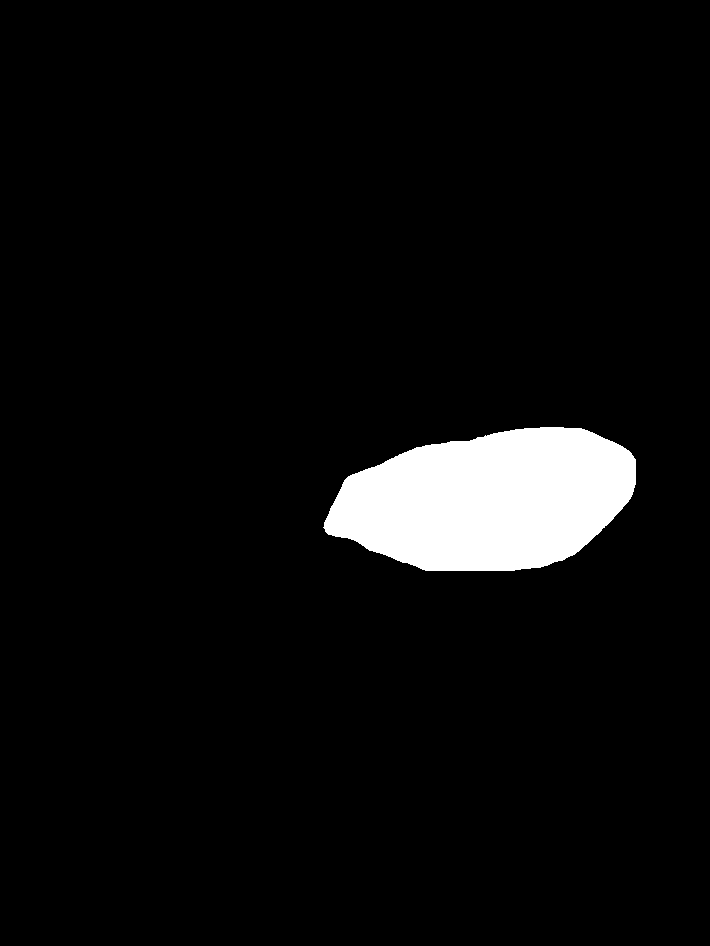

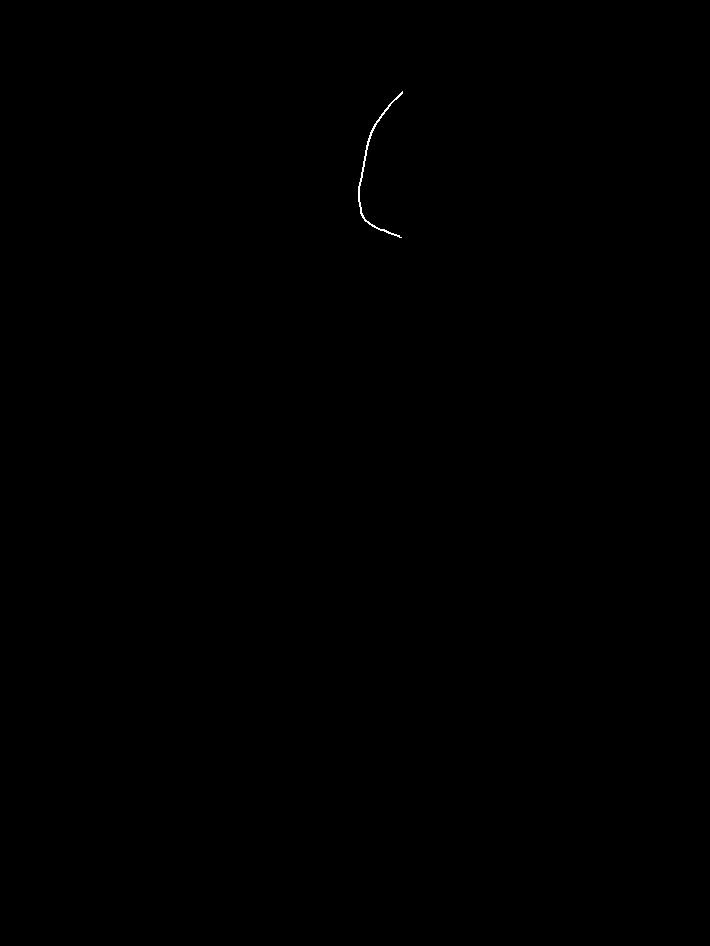

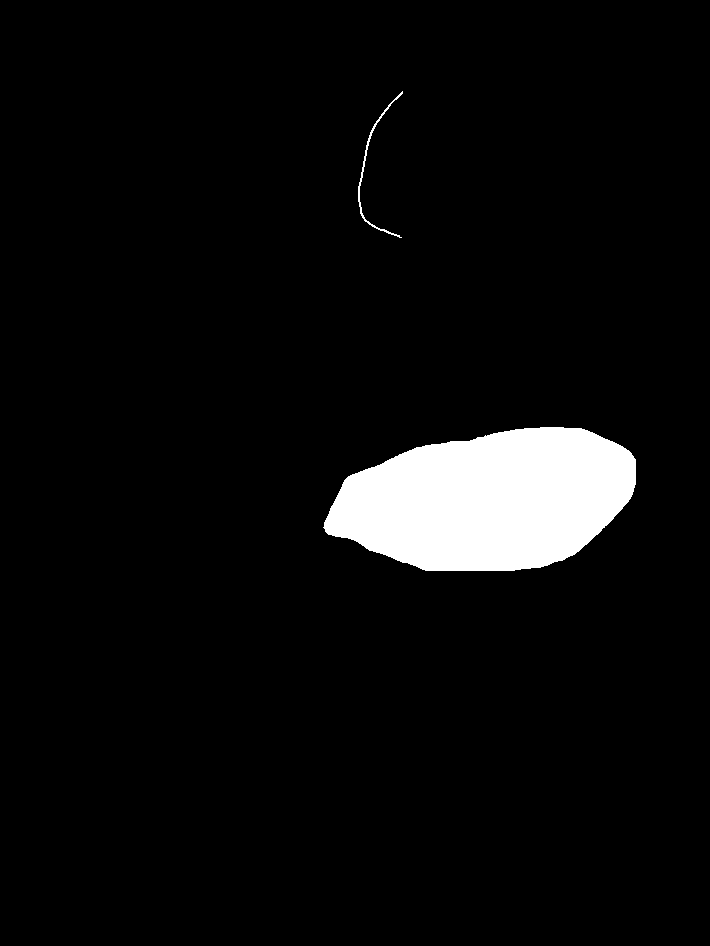

False

In [6]:
# Process annotation data
# NOTE: We assume there is only one annotation area per set of individual 
# annotated scars.
# TODO: this will need to change to handle multiple annotation areas
for record_id, record in records.items():
    # Get all annotation keys
    annot_keys = [key for key in list(record.keys()) if 'annotate' in key]
    annots_dict = {}
    for annot_key in annot_keys:
        if record[annot_key] != '':
            # Convert string JSON into dictionary
            annot_dict = json.loads(record[annot_key])
            # Add image from url
            annot_url = annot_dict['markers'][0]['drawingImgUrl']
            annot_img = Image.open(urllib.request.urlopen(annot_url))
            annot_dict['annot_img'] = annot_img
            annots_dict[annot_key] = annot_dict

# pprint(annots_dict)

# TODO: need to recreate annotations based on original image size
# Get area annotation image
test_area_name = 'bl_c_img_flf_annotate_all'
area_img_dict = annots_dict[test_area_name]
area_img = area_img_dict['annot_img']

# Get single annotation image
test_single_name = 'bl_c_flf1_annotate_scar'
sing_img_dict = annots_dict[test_single_name]
sing_img = sing_img_dict['annot_img']

# Create blank base to overlay annotations onto
orig_size = (area_img_dict['width'], area_img_dict['height'])
base_img = Image.new('RGB', orig_size)

# Align and overlay filled area annotation
left_align = area_img_dict['markers'][0]['left']
top_align = area_img_dict['markers'][0]['top']
area_overlay = base_img.copy()
area_overlay.paste(area_img, (left_align, top_align), area_img)
# Fill in overlay with a color other than black or white (e.g., magenta=255,0,255)
ImageDraw.floodfill(area_overlay, xy=(0, 0), value=(255, 0, 255), thresh=200)
# Make everything not magenta white
np_area = np.array(area_overlay)
np_area[(np_area[:, :, 0:3] != [255,0,255]).any(2)] = [255, 255, 255]
# Revert everthing else to black
np_area[(np_area[:, :, 0:3] == [255,0,255]).all(2)] = [0, 0, 0]
# Convert to bool area and compress to 1 image channel
np_area = np.array(np_area, dtype=bool).sum(axis=2, dtype=bool)

# Align and overlay single annotation
left_align = sing_img_dict['markers'][0]['left']
top_align = sing_img_dict['markers'][0]['top']
sing_overlay = base_img.copy()
sing_overlay.paste(sing_img, (left_align, top_align), sing_img)
np_sing = np.array(sing_overlay, dtype=bool).sum(axis=2, dtype=bool)

# If the intersection of the single and area annotation is not equal to the 
# annotation area then there exists a pixel in the single annotation that is 
# outside the annotation area
display(utils.bytes_to_img(np_area))
display(utils.bytes_to_img(np_sing))
display(utils.bytes_to_img(np.logical_or(np_sing, np_area)))
np_union = np.logical_or(np_sing, np_area)
np.array_equal(np_union, np_area)